In [1]:
import torch
from torchvision import datasets, transforms
import torchvision
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score

In [2]:
torch.manual_seed(42)

In [3]:
train_dataset=datasets.Food101(root='./data',download=True,split= 'train')
test_dataset=datasets.Food101(root='./data',download=True,split= 'test')

100%|██████████| 4996278331/4996278331 [00:33<00:00, 151109660.18it/s]


Extracting ./data/food-101.tar.gz to ./data


In [19]:
train_dataset.classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [18]:
train_dataset = datasets.Food101(root='./data', download=True, split='train', transform=transforms.ToTensor())

# Check the shape of  some images  in the dataset to also confirm the number of channels and image size
print(train_dataset[56][0].shape)
print(train_dataset[0][0].shape)

torch.Size([3, 384, 512])
torch.Size([3, 512, 512])


In [5]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Resize((256, 256)),transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((256, 256), scale=(0.75, 1))])

val_transforms = transforms.Compose([transforms.ToTensor(),transforms.Resize((256, 256))])

In [6]:
train_dataset = datasets.Food101(root='./data', download=False, split='train', transform=train_transforms)
val_dataset = datasets.Food101(root='./data', download=False, split='test', transform=val_transforms)


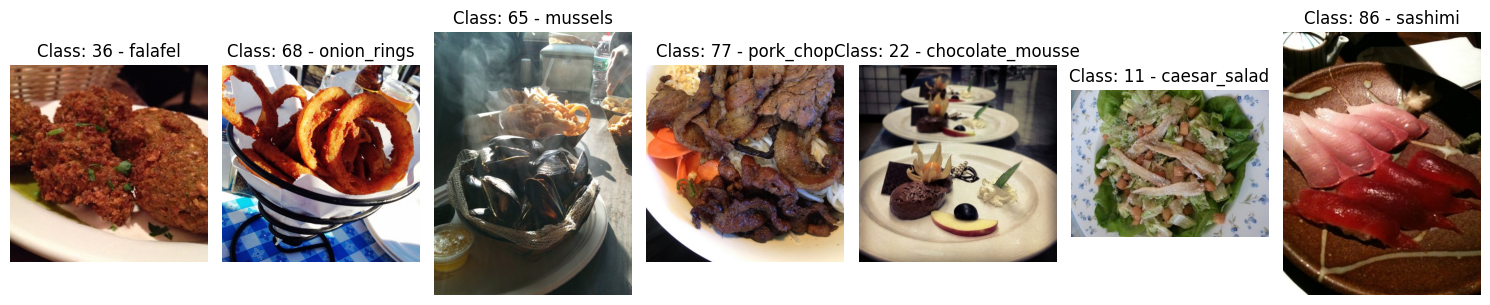

In [48]:
# Display a few images from the dataset along with their food category names and class numbers
num_images_to_display = 7

plt.figure(figsize=(15, 7))
for i in range(num_images_to_display):
    # Get a random image index
    idx = torch.randint(len(train_dataset), size=(1,)).item()

    # Retrieve the image and its corresponding label
    img, label = train_dataset[idx]

    # Get the class name corresponding to the label
    class_name = train_dataset.classes[label]

    # Plot the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img.permute(1, 2, 0))  # Matplotlib expects the color channel to be the last dimension
    plt.title(f"Class: {label} - {class_name}")
    plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

In [7]:
# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, )
print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 75750 train images and 25250 val images


In [8]:
 !pip install efficientnet_pytorch


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=38b0aae4247111e856c7e1ad9b3772e6601485915099919ddcc4bdeb54eaed8c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [9]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(in_features=1280, out_features=101)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 267MB/s]

Loaded pretrained weights for efficientnet-b0


In [10]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)


        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print(f'Training set:{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader)} Loss:{loss.item()})')
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [11]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    target_all = []
    predicted_all = []
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
            # Append scalar target and predicted values after moving into cpu
            target_all.extend(target.cpu().numpy())
            predicted_all.extend(predicted.cpu().numpy())


    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print(f'Validation set: Average loss: {avg_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset)}%)')
    # Calculate Precision, Recall, and F1-score using scikit-learn functions
    precision = round(precision_score(target_all, predicted_all, average='weighted'),2)
    recall = round(recall_score(target_all, predicted_all, average='weighted'),2)
    f1 = round(f1_score(target_all, predicted_all, average='weighted'),2)
    precision2 = round(precision_score(target_all, predicted_all, average='micro'),2)
    recall2 = round(recall_score(target_all, predicted_all, average='micro'),2)
    f1_2 = round(f1_score(target_all, predicted_all, average='micro'),2)
    accuracy = round((accuracy_score(target_all, predicted_all)*100),2)
    # Printing the accuracy
    print(f'Validation set: Average loss: {avg_loss},Accuracy: {accuracy}%, Weighted precision:{precision}, Weighted recall:{recall},Weighted f1:{f1}')
    print(f'Micro precision:{precision2}, Micro recall:{recall2}, Micro f1:{f1_2}')
   # return average loss for the epoch
    return avg_loss,accuracy, precision, recall, f1


In [12]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = model.to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
accuracy = []

# Train over  epochs
epochs = 20
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss[0])
        accuracy.append(test_loss[1])


Training on cuda
Epoch: 1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:4.6246538162231445)
Training set:640/75750 (0.8445945945945946 Loss:4.505284786224365)
Training set:1280/75750 (1.6891891891891893 Loss:4.321415901184082)
Training set:1920/75750 (2.5337837837837838 Loss:3.645277500152588)
Training set:2560/75750 (3.3783783783783785 Loss:3.2854530811309814)
Training set:3200/75750 (4.222972972972973 Loss:3.1331374645233154)
Training set:3840/75750 (5.0675675675675675 Loss:2.71018385887146)
Training set:4480/75750 (5.912162162162162 Loss:2.3399107456207275)
Training set:5120/75750 (6.756756756756757 Loss:2.50520920753479)
Training set:5760/75750 (7.601351351351352 Loss:2.285226821899414)
Training set:6400/75750 (8.445945945945946 Loss:2.2637126445770264)
Training set:7040/75750 (9.29054054054054 Loss:2.416304588317871)
Training set:7680/75750 (10.135135135135135 Loss:2.2177374362945557)
Training set:8320/75750 (10.97972972972973 Loss:2.287457227706909)
Training set:8960/75750 (11.824324324324325 Loss:1.8328560590744019)
Tr

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.7935667634010315)
Training set:640/75750 (0.8445945945945946 Loss:0.9395533204078674)
Training set:1280/75750 (1.6891891891891893 Loss:1.1685951948165894)
Training set:1920/75750 (2.5337837837837838 Loss:1.0007610321044922)
Training set:2560/75750 (3.3783783783783785 Loss:1.0741828680038452)
Training set:3200/75750 (4.222972972972973 Loss:1.357496976852417)
Training set:3840/75750 (5.0675675675675675 Loss:0.936224639415741)
Training set:4480/75750 (5.912162162162162 Loss:0.984021008014679)
Training set:5120/75750 (6.756756756756757 Loss:0.9726121425628662)
Training set:5760/75750 (7.601351351351352 Loss:0.8747307062149048)
Training set:6400/75750 (8.445945945945946 Loss:0.5767560601234436)
Training set:7040/75750 (9.29054054054054 Loss:0.9950500130653381)
Training set:7680/75750 (10.135135135135135 Loss:1.2806636095046997)
Training set:8320/75750 (10.97972972972973 Loss:0.9897451996803284)
Training set:8960/75750 (11.824324324324325 Loss:1.2458001375198

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.8071209192276001)
Training set:640/75750 (0.8445945945945946 Loss:0.8847696185112)
Training set:1280/75750 (1.6891891891891893 Loss:0.7932879328727722)
Training set:1920/75750 (2.5337837837837838 Loss:0.8217309713363647)
Training set:2560/75750 (3.3783783783783785 Loss:0.5609041452407837)
Training set:3200/75750 (4.222972972972973 Loss:0.8273100852966309)
Training set:3840/75750 (5.0675675675675675 Loss:0.9474755525588989)
Training set:4480/75750 (5.912162162162162 Loss:0.7427546381950378)
Training set:5120/75750 (6.756756756756757 Loss:0.7433148622512817)
Training set:5760/75750 (7.601351351351352 Loss:1.1394627094268799)
Training set:6400/75750 (8.445945945945946 Loss:0.8457704782485962)
Training set:7040/75750 (9.29054054054054 Loss:1.0041959285736084)
Training set:7680/75750 (10.135135135135135 Loss:0.8285696506500244)
Training set:8320/75750 (10.97972972972973 Loss:0.5320795774459839)
Training set:8960/75750 (11.824324324324325 Loss:0.6848897337913

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.7717309594154358)
Training set:640/75750 (0.8445945945945946 Loss:0.6947535276412964)
Training set:1280/75750 (1.6891891891891893 Loss:0.6467095613479614)
Training set:1920/75750 (2.5337837837837838 Loss:0.823436439037323)
Training set:2560/75750 (3.3783783783783785 Loss:0.614844560623169)
Training set:3200/75750 (4.222972972972973 Loss:0.7271544337272644)
Training set:3840/75750 (5.0675675675675675 Loss:0.6888834238052368)
Training set:4480/75750 (5.912162162162162 Loss:0.5527493357658386)
Training set:5120/75750 (6.756756756756757 Loss:0.7096042037010193)
Training set:5760/75750 (7.601351351351352 Loss:0.7234097719192505)
Training set:6400/75750 (8.445945945945946 Loss:0.3786626160144806)
Training set:7040/75750 (9.29054054054054 Loss:0.9453151822090149)
Training set:7680/75750 (10.135135135135135 Loss:0.682316243648529)
Training set:8320/75750 (10.97972972972973 Loss:0.6622116565704346)
Training set:8960/75750 (11.824324324324325 Loss:0.5051313638687

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.5941736102104187)
Training set:640/75750 (0.8445945945945946 Loss:0.376156210899353)
Training set:1280/75750 (1.6891891891891893 Loss:0.6668930053710938)
Training set:1920/75750 (2.5337837837837838 Loss:0.3567880392074585)
Training set:2560/75750 (3.3783783783783785 Loss:0.679553210735321)
Training set:3200/75750 (4.222972972972973 Loss:0.574278712272644)
Training set:3840/75750 (5.0675675675675675 Loss:0.8021941781044006)
Training set:4480/75750 (5.912162162162162 Loss:0.6420169472694397)
Training set:5120/75750 (6.756756756756757 Loss:0.6714114546775818)
Training set:5760/75750 (7.601351351351352 Loss:0.5529265999794006)
Training set:6400/75750 (8.445945945945946 Loss:0.44145792722702026)
Training set:7040/75750 (9.29054054054054 Loss:0.504546046257019)
Training set:7680/75750 (10.135135135135135 Loss:0.47421959042549133)
Training set:8320/75750 (10.97972972972973 Loss:0.45767033100128174)
Training set:8960/75750 (11.824324324324325 Loss:0.40205606818

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.42223355174064636)
Training set:640/75750 (0.8445945945945946 Loss:0.46422749757766724)
Training set:1280/75750 (1.6891891891891893 Loss:0.3757304549217224)
Training set:1920/75750 (2.5337837837837838 Loss:0.34916427731513977)
Training set:2560/75750 (3.3783783783783785 Loss:0.5822562575340271)
Training set:3200/75750 (4.222972972972973 Loss:0.5864933729171753)
Training set:3840/75750 (5.0675675675675675 Loss:0.7560226917266846)
Training set:4480/75750 (5.912162162162162 Loss:0.5517441034317017)
Training set:5120/75750 (6.756756756756757 Loss:0.5106896758079529)
Training set:5760/75750 (7.601351351351352 Loss:0.566476047039032)
Training set:6400/75750 (8.445945945945946 Loss:0.41560259461402893)
Training set:7040/75750 (9.29054054054054 Loss:0.3335030972957611)
Training set:7680/75750 (10.135135135135135 Loss:0.5680991411209106)
Training set:8320/75750 (10.97972972972973 Loss:0.4309203624725342)
Training set:8960/75750 (11.824324324324325 Loss:0.5722525

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.47042691707611084)
Training set:640/75750 (0.8445945945945946 Loss:0.24292437732219696)
Training set:1280/75750 (1.6891891891891893 Loss:0.29905733466148376)
Training set:1920/75750 (2.5337837837837838 Loss:0.3021697998046875)
Training set:2560/75750 (3.3783783783783785 Loss:0.3318565785884857)
Training set:3200/75750 (4.222972972972973 Loss:0.32854852080345154)
Training set:3840/75750 (5.0675675675675675 Loss:0.44153672456741333)
Training set:4480/75750 (5.912162162162162 Loss:0.3837011158466339)
Training set:5120/75750 (6.756756756756757 Loss:0.3465505838394165)
Training set:5760/75750 (7.601351351351352 Loss:0.43165284395217896)
Training set:6400/75750 (8.445945945945946 Loss:0.4734838008880615)
Training set:7040/75750 (9.29054054054054 Loss:0.7796753644943237)
Training set:7680/75750 (10.135135135135135 Loss:0.5332981944084167)
Training set:8320/75750 (10.97972972972973 Loss:0.5768172740936279)
Training set:8960/75750 (11.824324324324325 Loss:0.3259

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.49450480937957764)
Training set:640/75750 (0.8445945945945946 Loss:0.21787171065807343)
Training set:1280/75750 (1.6891891891891893 Loss:0.4618918299674988)
Training set:1920/75750 (2.5337837837837838 Loss:0.3728589415550232)
Training set:2560/75750 (3.3783783783783785 Loss:0.33862265944480896)
Training set:3200/75750 (4.222972972972973 Loss:0.2353004664182663)
Training set:3840/75750 (5.0675675675675675 Loss:0.3194260895252228)
Training set:4480/75750 (5.912162162162162 Loss:0.388226717710495)
Training set:5120/75750 (6.756756756756757 Loss:0.1442684531211853)
Training set:5760/75750 (7.601351351351352 Loss:0.16763028502464294)
Training set:6400/75750 (8.445945945945946 Loss:0.4028717875480652)
Training set:7040/75750 (9.29054054054054 Loss:0.775705099105835)
Training set:7680/75750 (10.135135135135135 Loss:0.3428119122982025)
Training set:8320/75750 (10.97972972972973 Loss:0.4155401885509491)
Training set:8960/75750 (11.824324324324325 Loss:0.47865769

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.36352360248565674)
Training set:640/75750 (0.8445945945945946 Loss:0.19088861346244812)
Training set:1280/75750 (1.6891891891891893 Loss:0.34127169847488403)
Training set:1920/75750 (2.5337837837837838 Loss:0.23491419851779938)
Training set:2560/75750 (3.3783783783783785 Loss:0.3611191213130951)
Training set:3200/75750 (4.222972972972973 Loss:0.3269377052783966)
Training set:3840/75750 (5.0675675675675675 Loss:0.5166139006614685)
Training set:4480/75750 (5.912162162162162 Loss:0.37964028120040894)
Training set:5120/75750 (6.756756756756757 Loss:0.3048149347305298)
Training set:5760/75750 (7.601351351351352 Loss:0.37948447465896606)
Training set:6400/75750 (8.445945945945946 Loss:0.39564669132232666)
Training set:7040/75750 (9.29054054054054 Loss:0.5684572458267212)
Training set:7680/75750 (10.135135135135135 Loss:0.3503926694393158)
Training set:8320/75750 (10.97972972972973 Loss:0.4050257205963135)
Training set:8960/75750 (11.824324324324325 Loss:0.236

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.3574300706386566)
Training set:640/75750 (0.8445945945945946 Loss:0.3916820287704468)
Training set:1280/75750 (1.6891891891891893 Loss:0.3010019063949585)
Training set:1920/75750 (2.5337837837837838 Loss:0.4622932970523834)
Training set:2560/75750 (3.3783783783783785 Loss:0.23662744462490082)
Training set:3200/75750 (4.222972972972973 Loss:0.20082706212997437)
Training set:3840/75750 (5.0675675675675675 Loss:0.32205185294151306)
Training set:4480/75750 (5.912162162162162 Loss:0.2299034297466278)
Training set:5120/75750 (6.756756756756757 Loss:0.32247868180274963)
Training set:5760/75750 (7.601351351351352 Loss:0.3273940682411194)
Training set:6400/75750 (8.445945945945946 Loss:0.19078126549720764)
Training set:7040/75750 (9.29054054054054 Loss:0.2607627213001251)
Training set:7680/75750 (10.135135135135135 Loss:0.2403179556131363)
Training set:8320/75750 (10.97972972972973 Loss:0.3098987638950348)
Training set:8960/75750 (11.824324324324325 Loss:0.41680

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.2764996290206909)
Training set:640/75750 (0.8445945945945946 Loss:0.2699645459651947)
Training set:1280/75750 (1.6891891891891893 Loss:0.21747611463069916)
Training set:1920/75750 (2.5337837837837838 Loss:0.2563689947128296)
Training set:2560/75750 (3.3783783783783785 Loss:0.24229544401168823)
Training set:3200/75750 (4.222972972972973 Loss:0.22296370565891266)
Training set:3840/75750 (5.0675675675675675 Loss:0.2050856053829193)
Training set:4480/75750 (5.912162162162162 Loss:0.3058190643787384)
Training set:5120/75750 (6.756756756756757 Loss:0.4239136874675751)
Training set:5760/75750 (7.601351351351352 Loss:0.25944945216178894)
Training set:6400/75750 (8.445945945945946 Loss:0.25646063685417175)
Training set:7040/75750 (9.29054054054054 Loss:0.20435622334480286)
Training set:7680/75750 (10.135135135135135 Loss:0.15355458855628967)
Training set:8320/75750 (10.97972972972973 Loss:0.18683351576328278)
Training set:8960/75750 (11.824324324324325 Loss:0.21

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.3460066318511963)
Training set:640/75750 (0.8445945945945946 Loss:0.20782972872257233)
Training set:1280/75750 (1.6891891891891893 Loss:0.12261264026165009)
Training set:1920/75750 (2.5337837837837838 Loss:0.2810172736644745)
Training set:2560/75750 (3.3783783783783785 Loss:0.4053574502468109)
Training set:3200/75750 (4.222972972972973 Loss:0.17462964355945587)
Training set:3840/75750 (5.0675675675675675 Loss:0.1753799170255661)
Training set:4480/75750 (5.912162162162162 Loss:0.5648687481880188)
Training set:5120/75750 (6.756756756756757 Loss:0.16158227622509003)
Training set:5760/75750 (7.601351351351352 Loss:0.20768550038337708)
Training set:6400/75750 (8.445945945945946 Loss:0.20166410505771637)
Training set:7040/75750 (9.29054054054054 Loss:0.4401495158672333)
Training set:7680/75750 (10.135135135135135 Loss:0.22295677661895752)
Training set:8320/75750 (10.97972972972973 Loss:0.18031610548496246)
Training set:8960/75750 (11.824324324324325 Loss:0.28

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.18270529806613922)
Training set:640/75750 (0.8445945945945946 Loss:0.15875934064388275)
Training set:1280/75750 (1.6891891891891893 Loss:0.16764108836650848)
Training set:1920/75750 (2.5337837837837838 Loss:0.16950975358486176)
Training set:2560/75750 (3.3783783783783785 Loss:0.31830063462257385)
Training set:3200/75750 (4.222972972972973 Loss:0.17893928289413452)
Training set:3840/75750 (5.0675675675675675 Loss:0.37203437089920044)
Training set:4480/75750 (5.912162162162162 Loss:0.23799604177474976)
Training set:5120/75750 (6.756756756756757 Loss:0.14336231350898743)
Training set:5760/75750 (7.601351351351352 Loss:0.23056915402412415)
Training set:6400/75750 (8.445945945945946 Loss:0.12623010575771332)
Training set:7040/75750 (9.29054054054054 Loss:0.24034114181995392)
Training set:7680/75750 (10.135135135135135 Loss:0.30624011158943176)
Training set:8320/75750 (10.97972972972973 Loss:0.10154004395008087)
Training set:8960/75750 (11.824324324324325 Los

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.18964911997318268)
Training set:640/75750 (0.8445945945945946 Loss:0.16665352880954742)
Training set:1280/75750 (1.6891891891891893 Loss:0.24931693077087402)
Training set:1920/75750 (2.5337837837837838 Loss:0.2059229612350464)
Training set:2560/75750 (3.3783783783783785 Loss:0.2003856748342514)
Training set:3200/75750 (4.222972972972973 Loss:0.4264117479324341)
Training set:3840/75750 (5.0675675675675675 Loss:0.2629460096359253)
Training set:4480/75750 (5.912162162162162 Loss:0.17398768663406372)
Training set:5120/75750 (6.756756756756757 Loss:0.3096482455730438)
Training set:5760/75750 (7.601351351351352 Loss:0.12140193581581116)
Training set:6400/75750 (8.445945945945946 Loss:0.09337418526411057)
Training set:7040/75750 (9.29054054054054 Loss:0.16400660574436188)
Training set:7680/75750 (10.135135135135135 Loss:0.32637158036231995)
Training set:8320/75750 (10.97972972972973 Loss:0.3690439760684967)
Training set:8960/75750 (11.824324324324325 Loss:0.20

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.22878994047641754)
Training set:640/75750 (0.8445945945945946 Loss:0.18906012177467346)
Training set:1280/75750 (1.6891891891891893 Loss:0.130801260471344)
Training set:1920/75750 (2.5337837837837838 Loss:0.1504288911819458)
Training set:2560/75750 (3.3783783783783785 Loss:0.19588765501976013)
Training set:3200/75750 (4.222972972972973 Loss:0.26730644702911377)
Training set:3840/75750 (5.0675675675675675 Loss:0.20553171634674072)
Training set:4480/75750 (5.912162162162162 Loss:0.086776502430439)
Training set:5120/75750 (6.756756756756757 Loss:0.15462517738342285)
Training set:5760/75750 (7.601351351351352 Loss:0.1869373321533203)
Training set:6400/75750 (8.445945945945946 Loss:0.2064601331949234)
Training set:7040/75750 (9.29054054054054 Loss:0.12826940417289734)
Training set:7680/75750 (10.135135135135135 Loss:0.24831539392471313)
Training set:8320/75750 (10.97972972972973 Loss:0.10866188257932663)
Training set:8960/75750 (11.824324324324325 Loss:0.345

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.23115095496177673)
Training set:640/75750 (0.8445945945945946 Loss:0.2961331307888031)
Training set:1280/75750 (1.6891891891891893 Loss:0.15440335869789124)
Training set:1920/75750 (2.5337837837837838 Loss:0.18754200637340546)
Training set:2560/75750 (3.3783783783783785 Loss:0.5684260725975037)
Training set:3200/75750 (4.222972972972973 Loss:0.4005570709705353)
Training set:3840/75750 (5.0675675675675675 Loss:0.24450837075710297)
Training set:4480/75750 (5.912162162162162 Loss:0.0669841319322586)
Training set:5120/75750 (6.756756756756757 Loss:0.12373668700456619)
Training set:5760/75750 (7.601351351351352 Loss:0.22000357508659363)
Training set:6400/75750 (8.445945945945946 Loss:0.07664844393730164)
Training set:7040/75750 (9.29054054054054 Loss:0.10274442285299301)
Training set:7680/75750 (10.135135135135135 Loss:0.21934057772159576)
Training set:8320/75750 (10.97972972972973 Loss:0.09651008993387222)
Training set:8960/75750 (11.824324324324325 Loss:0.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.39458364248275757)
Training set:640/75750 (0.8445945945945946 Loss:0.28567108511924744)
Training set:1280/75750 (1.6891891891891893 Loss:0.17871037125587463)
Training set:1920/75750 (2.5337837837837838 Loss:0.09815952926874161)
Training set:2560/75750 (3.3783783783783785 Loss:0.21417847275733948)
Training set:3200/75750 (4.222972972972973 Loss:0.23884986340999603)
Training set:3840/75750 (5.0675675675675675 Loss:0.2298019975423813)
Training set:4480/75750 (5.912162162162162 Loss:0.20586490631103516)
Training set:5120/75750 (6.756756756756757 Loss:0.14648078382015228)
Training set:5760/75750 (7.601351351351352 Loss:0.15342915058135986)
Training set:6400/75750 (8.445945945945946 Loss:0.1906508207321167)
Training set:7040/75750 (9.29054054054054 Loss:0.1246737688779831)
Training set:7680/75750 (10.135135135135135 Loss:0.09140969067811966)
Training set:8320/75750 (10.97972972972973 Loss:0.2440764158964157)
Training set:8960/75750 (11.824324324324325 Loss:0.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.11148148775100708)
Training set:640/75750 (0.8445945945945946 Loss:0.19172221422195435)
Training set:1280/75750 (1.6891891891891893 Loss:0.21725568175315857)
Training set:1920/75750 (2.5337837837837838 Loss:0.06416492164134979)
Training set:2560/75750 (3.3783783783783785 Loss:0.2501431405544281)
Training set:3200/75750 (4.222972972972973 Loss:0.21009856462478638)
Training set:3840/75750 (5.0675675675675675 Loss:0.17680087685585022)
Training set:4480/75750 (5.912162162162162 Loss:0.18222452700138092)
Training set:5120/75750 (6.756756756756757 Loss:0.036923594772815704)
Training set:5760/75750 (7.601351351351352 Loss:0.11313381046056747)
Training set:6400/75750 (8.445945945945946 Loss:0.11969316750764847)
Training set:7040/75750 (9.29054054054054 Loss:0.12394315749406815)
Training set:7680/75750 (10.135135135135135 Loss:0.33640217781066895)
Training set:8320/75750 (10.97972972972973 Loss:0.11692991107702255)
Training set:8960/75750 (11.824324324324325 Los

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.3452097177505493)
Training set:640/75750 (0.8445945945945946 Loss:0.1593666523694992)
Training set:1280/75750 (1.6891891891891893 Loss:0.12181909382343292)
Training set:1920/75750 (2.5337837837837838 Loss:0.03636578097939491)
Training set:2560/75750 (3.3783783783783785 Loss:0.07516323029994965)
Training set:3200/75750 (4.222972972972973 Loss:0.10623341798782349)
Training set:3840/75750 (5.0675675675675675 Loss:0.13180094957351685)
Training set:4480/75750 (5.912162162162162 Loss:0.10111507028341293)
Training set:5120/75750 (6.756756756756757 Loss:0.07931889593601227)
Training set:5760/75750 (7.601351351351352 Loss:0.09032327681779861)
Training set:6400/75750 (8.445945945945946 Loss:0.09924790263175964)
Training set:7040/75750 (9.29054054054054 Loss:0.21207605302333832)
Training set:7680/75750 (10.135135135135135 Loss:0.10725440084934235)
Training set:8320/75750 (10.97972972972973 Loss:0.1730244904756546)
Training set:8960/75750 (11.824324324324325 Loss:0

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set:0/75750 (0.0 Loss:0.16552715003490448)
Training set:640/75750 (0.8445945945945946 Loss:0.1452663093805313)
Training set:1280/75750 (1.6891891891891893 Loss:0.21222837269306183)
Training set:1920/75750 (2.5337837837837838 Loss:0.04939998686313629)
Training set:2560/75750 (3.3783783783783785 Loss:0.17864705622196198)
Training set:3200/75750 (4.222972972972973 Loss:0.07855719327926636)
Training set:3840/75750 (5.0675675675675675 Loss:0.10485973209142685)
Training set:4480/75750 (5.912162162162162 Loss:0.23823800683021545)
Training set:5120/75750 (6.756756756756757 Loss:0.07270675897598267)
Training set:5760/75750 (7.601351351351352 Loss:0.27663880586624146)
Training set:6400/75750 (8.445945945945946 Loss:0.19189287722110748)
Training set:7040/75750 (9.29054054054054 Loss:0.31784072518348694)
Training set:7680/75750 (10.135135135135135 Loss:0.39238426089286804)
Training set:8320/75750 (10.97972972972973 Loss:0.4047732651233673)
Training set:8960/75750 (11.824324324324325 Loss:

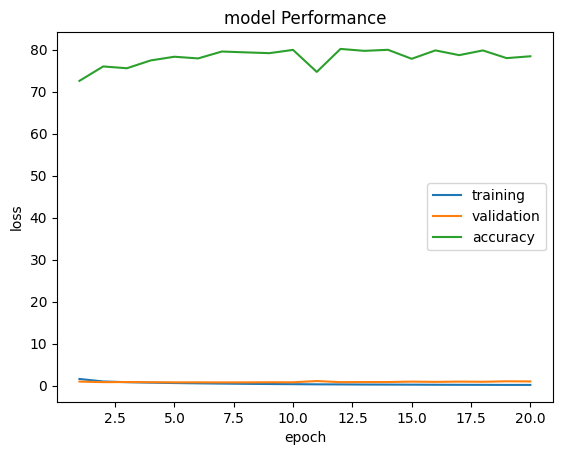

In [17]:
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.plot(epoch_nums, accuracy)
plt.title('model Performance')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation','accuracy'], loc='center right')
plt.show()

In [29]:
print(f'Max Accuracy is {max(accuracy)}%')
print(f'At Epoch {accuracy.index(max(accuracy))+1}')

Max Accuracy is 80.17%
At Epoch 12


In [30]:
print(f'Min Validation Loss is {min(validation_loss)}')
print(f'At Epoch {validation_loss.index(min(validation_loss))+1}')

Min Validation Loss is 0.8020186743875848
At Epoch 7
